In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import lightning as L
import torch
import torch.nn as nn
import torch.nn.functional as F
import yfinance as yf
import requests_cache as rc
import pickle as pkl
import sklearn as sk

import logging

# configure logging at the root level of Lightning
logging.getLogger("lightning.pytorch").setLevel(logging.ERROR)

%matplotlib inline
%load_ext tensorboard
sns.set_theme()

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Settings

In [159]:
train_size = 0.8 # train/test split
subsample = False # whether to randomly subsample the training data
subsample_size = 0.1 # fraction of training data to keep

# list of stock tickers to use, top 3 from S&P 500 sector by market cap
stock_tickers = ["META", "GOOGL", "NFLX", "AMZN", "TSLA", "HD", "PG", "COST", "PEP", "XOM", "CVX", "COP", "MA", "JPM", "V", "UNH", "JNJ", "LLY", "UNP", "BA", "CAT", "LIN", "SHW", "FCX", "PLD", "AMT", "EQIX", "MSFT", "AAPL", "AVGO", "NEE", "SO", "DUK"]
# stock_tickers = pd.read_csv("../data/sp500-firms.csv")["Symbol"].values.tolist()

lookback_window = 60 # num of days to look back
lookahead_window = 1 # num of days to look ahead

input_size = 2 # num feature channels (price, volume, sentiment, etc)
num_layers = 2 # num of stacked LSTM layers
hidden_size = 128 # num of nodes per LSTM layer
output_size = lookahead_window # lookahaed window size

max_epochs = 80 # max num of epochs to train for per ticker
learning_rate = 1e-4 # learning rate

# Model Setup

In [160]:
class StockPricePredictor(L.LightningModule):
    def __init__(self,
                 input_size: int,
                 hidden_size: int,
                 num_layers: int,
                 output_size: int,
                 learning_rate: float,
                 train_losses: list[int],
                 test_losses: list[int]):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)
        self.train_losses = train_losses
        self.test_losses = test_losses
        self.learning_rate = learning_rate
    
    def forward(self, x: torch.Tensor):
        out, _ = self.lstm(x)
        out = self.linear(out[:, -1, :])
        return out
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log("train_loss", loss, on_epoch=True, on_step=True, prog_bar=False)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log("val_loss", loss, on_epoch=True, on_step=True, prog_bar=False)
        return loss
    
    def on_train_epoch_end(self):
        self.train_losses.append(self.trainer.callback_metrics["train_loss"].item())
        self.test_losses.append(self.trainer.callback_metrics["val_loss"].item())

# Data Preprocessing

In [161]:
session = rc.CachedSession("sentiment-model-7.cache")

sp500_download = yf.download(
    tickers=stock_tickers,
    period="10y",
    interval="1d",
    # session=session
)

[*********************100%%**********************]  33 of 33 completed


In [79]:
with open("../data/post-firm-sentiment.pkl", "rb") as f:
    sentiment_df = pkl.load(f)

sentiment_df.set_index("created", inplace=True)
sentiment_df.index = sentiment_df.index.values.astype("datetime64[D]")
sentiment_df.index.name = "Date"
sentiment_df = sentiment_df.rename(columns=lambda x: x.replace("is_", ""))
sentiment_df = sentiment_df.rename(columns={"sentiment_score": "Sentiment"})
sentiment_df = sentiment_df.drop("selftext", axis=1)
sentiment_df = sentiment_df.reset_index()


tickers = sentiment_df.columns.drop(["Date", "Sentiment"])
sentiment_df = sentiment_df.melt(id_vars=["Date", "Sentiment"], var_name="Ticker", value_name="Count")
sentiment_df = sentiment_df[sentiment_df["Count"] == 1].drop("Count", axis=1).reset_index(drop=True)

# for each Ticker, aggregate sentiment by Date (mean)
sentiment_df = sentiment_df.groupby(["Date", "Ticker"]).mean().reset_index()

In [80]:
with open("../data/analyst_ratings_processed.pkl", "rb") as f:
    analyst_ratings_df = pkl.load(f)

analyst_ratings_df["date"] = analyst_ratings_df["date"].values.astype("datetime64[D]")
analyst_ratings_df = analyst_ratings_df.groupby(["date", "stock"]).mean().reset_index()
analyst_ratings_df = analyst_ratings_df.rename(columns={"stock": "Ticker", "date": "Date"})

In [81]:
# sentiment_df
analyst_ratings_df

,Date,Ticker,sentiment
0,2009-02-14,NAV,0.2263
1,2009-04-27,FT,0.0000
2,2009-04-27,Y,0.0000
3,2009-04-29,A,0.0000
4,2009-05-22,AM,0.0000
...,...,...,...
836982,2020-06-11,XRX,0.6705
836983,2020-06-11,XYL,0.3182
836984,2020-06-11,YELP,0.0000
836985,2020-06-11,YUM,0.1438


In [9]:
sentiment_df = sentiment_df.merge(analyst_ratings_df, on=["Date", "Ticker"], how="outer")
sentiment_df["Sentiment"] = sentiment_df.apply(lambda row: np.nanmean([row["Sentiment"], row["sentiment"]]), axis=1)
sentiment_df = sentiment_df.drop("sentiment", axis=1)
sentiment_df = sentiment_df.sort_values(["Date", "Ticker"])
sentiment_df

,Date,Ticker,Sentiment
19279,2009-02-14,NAV,0.226300
19280,2009-04-27,FT,0.000000
19281,2009-04-27,Y,0.000000
19282,2009-04-29,A,0.000000
19283,2009-05-22,AM,0.000000
...,...,...,...
19274,2021-12-31,TGT,-0.553700
19275,2021-12-31,TMO,0.987300
19276,2021-12-31,TSLA,0.971367
19277,2021-12-31,V,0.984800


In [82]:
sp500_price_df = sp500_download["Close"].fillna(0)
sp500_price_df.index = pd.to_datetime(sp500_price_df.index)
sp500_price_df = sp500_price_df.reset_index().melt(id_vars="Date", var_name="Ticker", value_name="Price")
sp500_price_df["Date"] = pd.to_datetime(sp500_price_df['Date'])
sp500_price_df = sp500_price_df[sp500_price_df["Price"] != 0]

sp500_volume_df = sp500_download["Volume"].fillna(0)
sp500_volume_df.index = pd.to_datetime(sp500_volume_df.index)
sp500_volume_df = sp500_volume_df.reset_index().melt(id_vars="Date", var_name="Ticker", value_name="Volume")
sp500_volume_df["Date"] = pd.to_datetime(sp500_volume_df['Date'])
sp500_df = sp500_price_df.merge(sp500_volume_df, on=["Date", "Ticker"], how="left").fillna(0)
# sp500_df = sp500_df[(sp500_df["Date"] >= "2021-01-01") & (sp500_df["Date"] <= "2021-12-31")]

In [87]:
sp500_sentiment_df = sp500_df.merge(sentiment_df, on=["Date", "Ticker"], how="left").fillna(0)

# Dataset Preparation

In [162]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
def split_data(df: pd.DataFrame,
               train_size: float = 0.8,
               lbp: int = 30,
               lfp: int = 1) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, StandardScaler]:
    """
    lbp: look back period
    lfp: look forward period
    """
    X_train = []
    y_train = []
    X_test = []
    y_test = []

    tickers = df["Ticker"].unique()

    for ticker in tickers:
        ticker_df = df[df["Ticker"] == ticker]
        ticker_df = ticker_df.drop("Ticker", axis=1)
        ticker_df = ticker_df.set_index("Date")
        ticker_array = ticker_df.sort_index().values
        
        train_count = int(ticker_array.shape[0] * train_size)
        train = ticker_array[:train_count]
        test = ticker_array[train_count:]

        ticker_X_train = []
        ticker_y_train = []
        ticker_X_test = []
        ticker_y_test = []


        for i in range(lbp, train.shape[0] - lfp + 1):
            ticker_X_train.append(train[i - lbp:i, :])
            ticker_y_train.append(train[i:i + lfp, 0])
        
        for i in range(lbp, test.shape[0] - lfp + 1):
            ticker_X_test.append(test[i - lbp:i, :])
            ticker_y_test.append(test[i:i + lfp, 0])

        X_train.append(ticker_X_train)
        y_train.append(ticker_y_train)
        X_test.append(ticker_X_test)
        y_test.append(ticker_y_test)
    
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    X_scaler = StandardScaler()
    y_scaler = StandardScaler()
    X_train = X_scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    X_test = X_scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
    y_train = y_scaler.fit_transform(y_train.reshape(-1, y_train.shape[-1])).reshape(y_train.shape)
    y_test = y_scaler.transform(y_test.reshape(-1, y_test.shape[-1])).reshape(y_test.shape)

    return X_train, y_train, X_test, y_test, y_scaler

(X_train, y_train, X_test, y_test, y_scaler) = split_data(sp500_df, train_size=train_size, lbp=lookback_window, lfp=lookahead_window)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (33, 1954, 60, 2)
y_train shape: (33, 1954, 1)
X_test shape: (33, 444, 60, 2)
y_test shape: (33, 444, 1)


In [163]:
from torch.utils.data import TensorDataset, DataLoader

train_datasets = []
test_datasets = []

train_dataloaders = []
test_dataloaders = []

for i in range(X_train.shape[0]):
    train_datasets.append(TensorDataset(torch.from_numpy(X_train[i]).float(), torch.from_numpy(y_train[i]).float()))
    test_datasets.append(TensorDataset(torch.from_numpy(X_test[i]).float(), torch.from_numpy(y_test[i]).float()))

for i in range(X_train.shape[0]):
    train_dataloaders.append(DataLoader(train_datasets[i], batch_size=64, shuffle=True))
    test_dataloaders.append(DataLoader(test_datasets[i], batch_size=64, shuffle=False))

# train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
# test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

# train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=11, persistent_workers=True)
# test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=11, persistent_workers=True)

# Model Training

In [164]:
train_losses = []
test_losses = []
model = StockPricePredictor(input_size, hidden_size, num_layers, output_size,
                            learning_rate=learning_rate, train_losses=train_losses, test_losses=test_losses)

for train_dataloader, test_dataloader in zip(train_dataloaders, test_dataloaders):
    trainer = L.Trainer(max_epochs=max_epochs, accelerator="gpu", enable_progress_bar=False)
    trainer.fit(model, train_dataloader, test_dataloader)
    
print("Done")

/Users/pranav/Projects/cos497/venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/pranav/Projects/cos497/venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/pranav/Projects/cos497/venv/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (31) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Done


In [165]:
train_losses = np.array(train_losses).reshape(-1, max_epochs)
test_losses = np.array(test_losses).reshape(-1, max_epochs)

Text(0, 0.5, 'Loss (RMSE)')

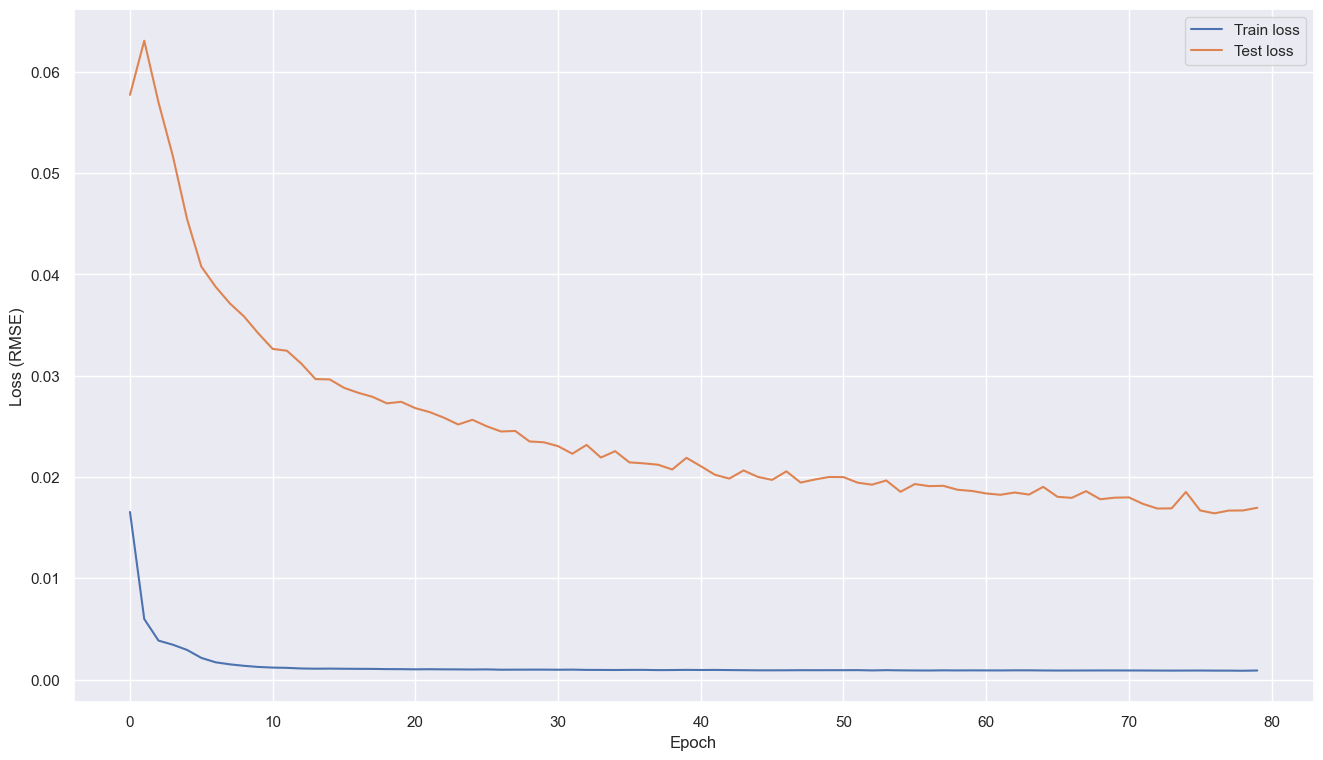

In [166]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
sns.lineplot(data=train_losses.mean(axis=0), ax=ax, label="Train loss")
sns.lineplot(data=test_losses.mean(axis=0), ax=ax, label="Test loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss (RMSE)")

## Forecasting Test (Open-loop forecasting)

[*********************100%%**********************]  1 of 1 completed
RMSE = 1.5853


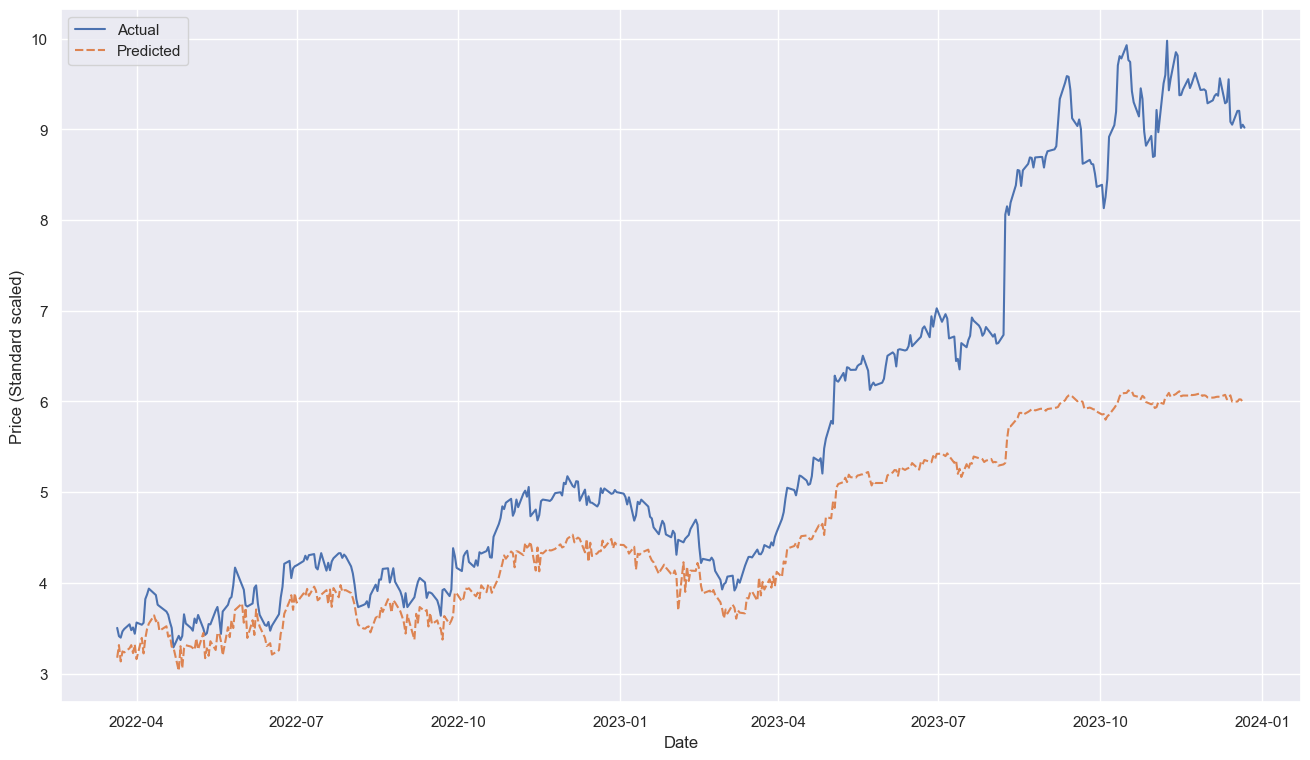

In [168]:
test_ticker = "LLY"

test_download = yf.download(
    tickers=[test_ticker],
    period="10y",
    interval="1d",
)


test_df = test_download[["Close", "Volume"]].fillna(0)
test_df = test_df.reset_index()
test_df["Ticker"] = test_ticker
# test_df = test_df[(test_df["Date"] >= "2021-01-01") & (test_df["Date"] <= "2021-12-31")]

# comment next line to not use sentiment
# test_df = test_df.merge(sentiment_df, on=["Date", "Ticker"], how="left").fillna(0)

test_X_train, test_y_train, test_X_test, test_y_test, test_y_scaler = split_data(test_df, train_size=train_size, lbp=lookback_window, lfp=lookahead_window)


model.eval()

samples = test_X_test.shape[1]

y = []
y_hat = []

for sample in range(samples):
    X_sample = test_X_test[0, sample:sample + 1]
    y_sample = test_y_test[0, sample:sample + 1][0,0]

    with torch.no_grad():
        y_hat.append(model(torch.from_numpy(X_sample).float()).numpy()[0][0])
        y.append(y_sample)

y = np.array(y)
y_hat = np.array(y_hat)

# unscale
# y = y_scaler.inverse_transform(y.reshape(-1, 1)).reshape(-1)
# y_hat = y_scaler.inverse_transform(y_hat.reshape(-1, 1)).reshape(-1)
rmse = np.sqrt(np.mean((y - y_hat) ** 2))

plot_df = pd.DataFrame({
    "Actual": y,
    "Predicted": y_hat
}, index=test_df["Date"][-len(y):])

fig, ax = plt.subplots(figsize=(16, 9))
sns.lineplot(data=plot_df, ax=ax)
ax.set_ylabel("Price (Standard scaled)")
ax.legend()
print(f"RMSE = {rmse:.4f}")

### Model Evaluation (RMSE calculation)

In [170]:
rmses = []
test_tickers = "CMCSA CHTR EA MCD NKE LOW KO WMT PM EOG SLB PSX BAC WFC SPGI ABBV MRK TMO GE HON UBER APD ECL NEM WELL CCI PSA NVDA ADBE CRM SRE AEP D".split(" ")

# for test_ticker in stock_tickers:
for test_ticker in test_tickers:
    
    test_download = yf.download(
        tickers=[test_ticker],
        period="10y",
        interval="1d",
        # session=session
    )


    test_df = test_download[["Close", "Volume"]].fillna(0)
    test_df = test_df.reset_index()
    test_df["Ticker"] = test_ticker
    # test_df = test_df[(test_df["Date"] >= "2021-01-01") & (test_df["Date"] <= "2021-12-31")]

    # comment next line to not use sentiment
    # test_df = test_df.merge(sentiment_df, on=["Date", "Ticker"], how="left").fillna(0)

    test_X_train, test_y_train, test_X_test, test_y_test, test_y_scaler = split_data(test_df, train_size=train_size, lbp=lookback_window, lfp=lookahead_window)


    model.eval()

    ticker = 0
    samples = test_X_test.shape[1]

    y = []
    y_hat = []

    for sample in range(samples):
        X_sample = test_X_test[ticker, sample:sample + 1]
        y_sample = test_y_test[ticker, sample:sample + 1][0,0]

        with torch.no_grad():
            y_hat.append(model(torch.from_numpy(X_sample).float()).numpy()[0][0])
            y.append(y_sample)

    y = np.array(y)
    y_hat = np.array(y_hat)

    # unscale
    # y = y_scaler.inverse_transform(y.reshape(-1, 1)).reshape(-1)
    # y_hat = y_scaler.inverse_transform(y_hat.reshape(-1, 1)).reshape(-1)
    rmse = np.sqrt(np.mean((y - y_hat) ** 2))
    print(f"{test_ticker} RMSE = {rmse:.4f}")
    rmses.append(rmse)

rmses = np.array(rmses)
print(f"Mean RMSE = {rmses.mean():.4f}")

[*********************100%%**********************]  1 of 1 completed
CMCSA RMSE = 0.1309
[*********************100%%**********************]  1 of 1 completed
CHTR RMSE = 0.1013
[*********************100%%**********************]  1 of 1 completed
EA RMSE = 0.1228
[*********************100%%**********************]  1 of 1 completed
MCD RMSE = 0.1953
[*********************100%%**********************]  1 of 1 completed
NKE RMSE = 0.2548
[*********************100%%**********************]  1 of 1 completed
LOW RMSE = 0.1056
[*********************100%%**********************]  1 of 1 completed
KO RMSE = 0.4868
[*********************100%%**********************]  1 of 1 completed
WMT RMSE = 0.2896
[*********************100%%**********************]  1 of 1 completed
PM RMSE = 0.2215
[*********************100%%**********************]  1 of 1 completed
EOG RMSE = 0.3423
[*********************100%%**********************]  1 of 1 completed
SLB RMSE = 0.0928
[*********************100%%****************